In [1]:
from tqdm import tqdm
import math
import random

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from operator import itemgetter

import cv2
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

## Load and process dataset
### Train Steerings & Speeds

8514


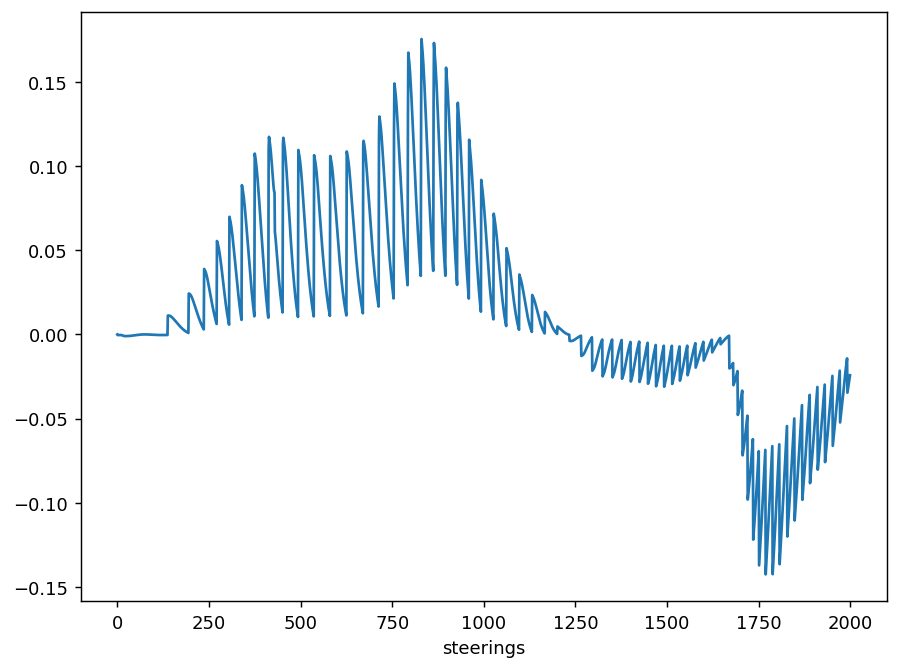

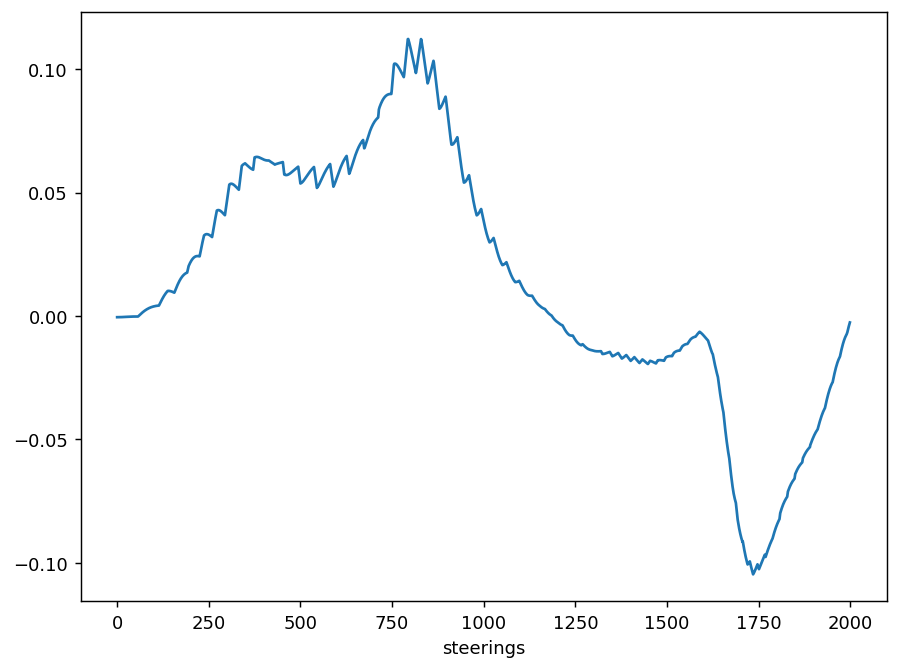

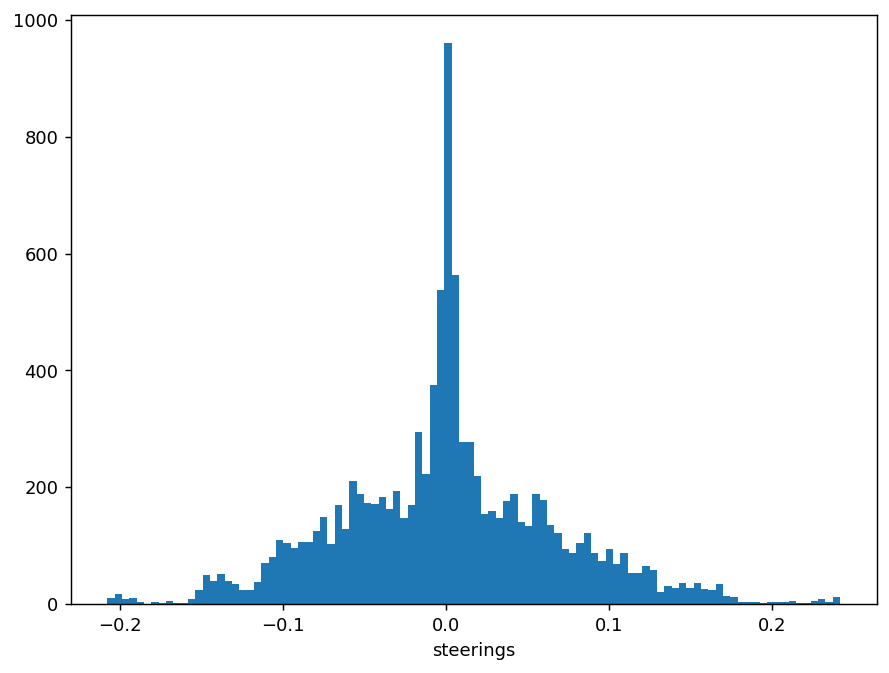

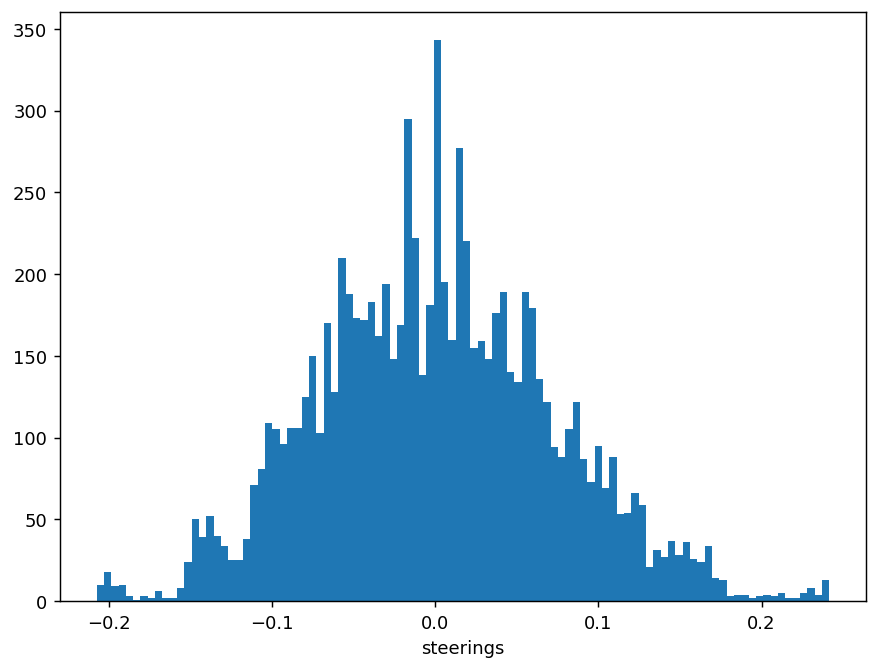

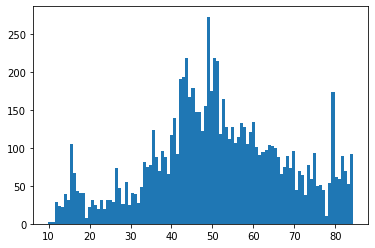

In [17]:
steeringFile = open("../dataset/CW-files/steering.txt")  
revSteeringFile = open("../dataset/CC-files/steering.txt")
speedFile = open("../dataset/CW-files/speed.txt")
revSpeedFile = open("../dataset/CC-files/speed.txt")

steerings = steeringFile.readlines()
revSteerings = revSteeringFile.readlines()
speeds = speedFile.readlines()
revSpeeds = revSpeedFile.readlines()

formatedSteerings = []
formatedRevSteerings = []
formatedSpeeds = []
formatedRevSpeeds = []
for string in steerings:
    new_string = string.replace("\n", "")
    formatedSteerings.append(float(new_string))
for string in revSteerings:
    new_string = string.replace("\n", "")
    formatedRevSteerings.append(float(new_string))
for string in speeds:
    new_string = string.replace("\n", "")
    formatedSpeeds.append(float(new_string))
for string in revSpeeds:
    new_string = string.replace("\n", "")
    formatedRevSpeeds.append(float(new_string))

plt.figure(figsize=(8,6), dpi = 130)
plt.xlabel("steerings")
plt.plot(formatedSteerings[0:2000])

# Remove oscillations in the steering value with a window average
N=81 # odd nb for simplicity
avgSteerings = np.convolve(formatedSteerings, np.ones(N)/N, mode='valid')
avgRevSteerings = np.convolve(formatedRevSteerings, np.ones(N)/N, mode='valid')

plt.figure(figsize=(8,6), dpi = 130)
plt.xlabel("steerings")
plt.plot(avgSteerings[0:2000])

idxFormatedSteerings = list(enumerate(avgSteerings, int((N-1)/2)))
idxFormatedRevSteerings = list(enumerate(avgRevSteerings,int((N-1)/2)))

idxFormatedSpeeds = list(enumerate(formatedSpeeds))
idxFormatedRevSpeeds = list(enumerate(formatedRevSpeeds))

# Only keep even indexes of steering and speed values
idxFormatedSteerings = idxFormatedSteerings[::2] 
idxFormatedRevSteerings = idxFormatedRevSteerings[::2] 
idxFormatedSpeeds = idxFormatedSpeeds[::2] 
idxFormatedRevSpeeds = idxFormatedRevSpeeds[::2] 

allSteerings = list(idxFormatedSteerings) + list(idxFormatedRevSteerings)
allSpeeds = idxFormatedSpeeds[int((N-1)/4):-int((N-1)/4)] + idxFormatedRevSpeeds[int(N/4):-int(N/4)]

plt.figure(figsize=(8,6), dpi = 130)
plt.xlabel("steerings")
hist0 = plt.hist(list(map((lambda x: x[1]), allSteerings)), bins = 100)

# Filter steerings around 0 which are too numerous
filtered = list(filter(lambda x: x[1][1] <= 0.01 and x[1][1] >= -0.01, list(enumerate(allSteerings))))
reducedFilteredTuples = random.sample(list(filtered),int(len(filtered)*(1-0.35)))
indexes, _ = zip(*reducedFilteredTuples)

for ele in sorted(indexes, reverse = True):
    del allSteerings[ele]
    del allSpeeds[ele]

previousSplit = 0;
for idx,steer in enumerate(allSteerings):
    if steer[0] < previousSplit:
        split = idx;
    previousSplit = steer[0]

allSteerings[:split] = [(0, x) for x in allSteerings[:split]]
allSteerings[split:] = [(1, x) for x in allSteerings[split:]]

# Random order for training part
randomIdx = list(np.random.permutation(len(allSteerings)))
allSteerings = [allSteerings[i] for i in randomIdx]
allSpeeds = [allSpeeds[i] for i in randomIdx]

# Distribution of speed and steering values
plt.figure(figsize=(8,6), dpi = 130)
plt.xlabel("steerings")
hist1 = plt.hist(list(map((lambda x: x[1][1]), allSteerings)), bins = 100)
plt.figure()
hist2 = plt.hist(list(map((lambda x: x[1]), allSpeeds)), bins = 100)

print(len(allSteerings))

### Images

In [4]:
# Import images and augment data by flipping each image around y axis
def import_img_batch_train(start, end):
    images = []
    
    for direction,x in allSteerings[start:end]:
        if(direction == 0):
            img_center = cv2.imread('../dataset/CW-images/center_' + str(x[0]) + '.png').astype(np.float32)
            flip_img_center = cv2.flip(img_center, 1)
            img_left = cv2.imread('../dataset/CW-images/left_' + str(x[0]) + '.png').astype(np.float32)
            flip_img_left = cv2.flip(img_left, 1)
            img_right = cv2.imread('../dataset/CW-images/right_' + str(x[0]) + '.png').astype(np.float32)
            flip_img_right = cv2.flip(img_right, 1)
        else:
            img_center = cv2.imread('../dataset/CC-images/center_' + str(x[0]) + '.png').astype(np.float32)
            flip_img_center = cv2.flip(img_center, 1)
            img_left = cv2.imread('../dataset/CC-images/left_' + str(x[0]) + '.png').astype(np.float32)
            flip_img_left = cv2.flip(img_left, 1)
            img_right = cv2.imread('../dataset/CC-images/right_' + str(x[0]) + '.png').astype(np.float32)
            flip_img_right = cv2.flip(img_right, 1)
        images.append(img_center)
        images.append(flip_img_center)
        images.append(img_left)
        images.append(flip_img_left)
        images.append(img_right)
        images.append(flip_img_right)
    return images

In [5]:
# Compute mean and standard deviation per mini-batch
ncum = list(range(0,len(allSteerings),50)) + [len(allSteerings)]
ncum = np.array(ncum)
n = ncum.copy()
n[1:] -= n[:-1].copy()
n = np.delete(n, 0)

means = []
stds = []

for i in tqdm(range(len(n))):
    train_input = torch.from_numpy(np.array(import_img_batch_train(ncum[i],ncum[i+1]))).permute(0, 3, 1, 2)
    means.append(torch.mean(train_input, dim=[0,2,3]))
    stds.append(torch.std(train_input, dim=[0,2,3]))
del train_input

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:52<00:00,  3.27it/s]


In [6]:
# Compute general mean and std for complete dataset
total = sum(n)
sumx = []
sumx2 = []

for i in range(len(n)):
    sumx.append(means[i] * n[i])

for i in range(len(n)):
    sumx2.append(stds[i]**2 * (n[i]-1) + (sumx[i]**2/n[i])) 

mean = sum(sumx)/total
std = torch.sqrt((sum(sumx2)-sum(sumx)**2 /total) / (total-1))
print(mean,std)

tensor([75.6147, 80.3602, 82.3966]) tensor([40.8443, 50.6416, 55.5742])


In [7]:
# Duplicate labels for the three images (center, left, right)
train_labels = list(zip(list(map((lambda x: x[1][1]), allSteerings)),list(map((lambda x: x[1]), allSpeeds))))
train_labels = [x for pair in zip(train_labels,train_labels,train_labels) for x in pair]
train_target0 = []

# Add offset to left and right camera to push car to center of line
for idx, x in enumerate(train_labels):
    if(idx % 3 == 0):
        train_target0.append(x)
    elif(idx % 3 == 1):
        train_target0.append((x[0]+0.08, x[1]))
    elif(idx % 3 == 2):
        train_target0.append((x[0]-0.08, x[1]))

train_target0 = [x for pair in zip(train_target0,train_target0) for x in pair]
train_target = []

# Invert steering for flipped images
for idx, x in enumerate(train_target0):
    if(idx % 2 == 0):
        train_target.append(x)
    else:
        train_target.append((-x[0], x[1]))

# Normalize output labels
train_target = torch.from_numpy(np.array(train_target).astype(np.float32))
target_mean = torch.mean(train_target, dim=0)
target_std = torch.std(train_target, dim=0)
train_target[:,0].sub_(target_mean[0]).div_(target_std[0])
train_target[:,1].sub_(target_mean[1]).div_(target_std[1])
print(target_mean, target_std)

tensor([ 0.0000, 51.2255]) tensor([ 0.1107, 16.7702])


## Training

In [8]:
def train_model(dvc, model, train_target, nb_train_batches, train_batches_size, mu, std):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    
    for e in (range(0, 20)):
        sum_loss = 0
        print(e)
        model.train()
        for b in tqdm(range(0, nb_train_batches)):
            
            # Load batch
            input_batch = torch.from_numpy(np.array(import_img_batch_train(train_batches_size[b], train_batches_size[b+1]))).permute(0, 3, 1, 2)
            
            # Apply normalization
            for channel in range(3):
                input_batch[:,channel,:,:].sub_(mu[channel]).div_(std[channel])
                
            # Push to GPU  
            input_batch = input_batch.to(dvc) 
            model = model.to(dvc)
            train_target = train_target.to(dvc)
            
            # Compute forward prop and loss
            output = model(input_batch)
            loss = criterion(output, train_target[train_batches_size[b]*6:train_batches_size[b+1]*6])
            sum_loss += float(loss.item())
            
            # Apply backward prop and learning step
            model.zero_grad()
            loss.backward()
            optimizer.step()
                    
        print("train loss = " + str(sum_loss))

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(19456, 500)
        self.fc2 = nn.Linear(500, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.elu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.elu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.elu(F.max_pool2d(self.conv3(x), kernel_size=2))
        x = F.elu(self.fc1(x.reshape(-1, 19456)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet()

train_model(device, model, train_target, len(n), ncum , mean, std)
torch.save(model.state_dict(), "offsetModel.pt")

0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:39<00:00,  3.95it/s]


error number = 0
train loss = 160.78973807394505
test loss = 79.49374267458916
1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 16.25it/s]


error number = 0
train loss = 39.0850128531456
test loss = 83.29308551549911
2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 14.60it/s]


error number = 0
train loss = 23.51078874617815
test loss = 89.38823175430298
3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 15.30it/s]


error number = 0
train loss = 16.775342032313347
test loss = 85.6672976911068
4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.64it/s]


error number = 0
train loss = 13.06321157887578
test loss = 89.5964344739914
5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.36it/s]


error number = 0
train loss = 10.738068085163832
test loss = 82.43070274591446
6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.72it/s]


error number = 0
train loss = 9.241426672786474
test loss = 84.64656685292721
7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.68it/s]


error number = 0
train loss = 8.065815273672342
test loss = 83.89342747628689
8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.41it/s]


error number = 0
train loss = 6.983826518058777
test loss = 79.00785468518734
9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.05it/s]


error number = 0
train loss = 6.121660524979234
test loss = 84.89416143298149
10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.08it/s]


error number = 0
train loss = 5.6285031251609325
test loss = 87.42078495025635
11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.44it/s]


error number = 0
train loss = 5.297428663820028
test loss = 87.06976120173931
12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.32it/s]


error number = 0
train loss = 5.0515336617827415
test loss = 89.16389338672161
13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 15.56it/s]


error number = 0
train loss = 4.472971774637699
test loss = 84.40785676240921
14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.48it/s]


error number = 0
train loss = 4.005234986543655
test loss = 79.04001028835773
15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.52it/s]


error number = 0
train loss = 3.6770181488245726
test loss = 79.41081061959267
16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.03it/s]


error number = 0
train loss = 3.5244785947725177
test loss = 78.21408273279667
17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.55it/s]


error number = 0
train loss = 3.372617502696812
test loss = 80.96024587750435
18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.88it/s]


error number = 0
train loss = 3.312839857302606
test loss = 75.33271650969982
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 14.09it/s]

error number = 0
train loss = 3.310319408774376
test loss = 82.85464397072792


## Write model parameters to txt

In [25]:
model = ConvNet()
model.load_state_dict(torch.load("offsetModel.pt"))
weights = []
bias = []
for idx,param in enumerate(model.parameters()):
    if(idx % 2 == 0):
        weights.append(param)
    else:
        bias.append(param)

In [62]:
bfile1 = open('../controllers/CNN_autonomous_car_cpu_fixed/model/biases.txt', 'a')
bfile2 = open('../controllers/CNN_autonomous_car_cpu_float/model/biases.txt', 'a')

for x in bias:
    for y in x:
        #print(y.item())
        bfile1.write(str(y.item()) + "\n")
        bfile2.write(str(y.item()) + "\n")
        
bfile1.close()
bfile2.close()

-0.19373098015785217
-0.12436173111200333
0.02378862537443638
-0.06613484025001526
0.14285419881343842
0.10181687027215958
0.06070948764681816
-0.05611620470881462
-0.13737328350543976
-0.10821224004030228
-0.028682168573141098
-0.17293068766593933
0.13489791750907898
-0.09463856369256973
-0.08785495162010193
0.09965821355581284
0.04067305102944374
0.02549494244158268
0.011077598668634892
-0.057757750153541565
0.0725845918059349
-0.0003131136763840914
0.030524136498570442
-0.08588384091854095
0.04040534049272537
0.043825097382068634
0.07456231862306595
0.034759294241666794
-0.012878533452749252
0.03540694713592529
0.02438945509493351
-0.0915769562125206
-0.04263507202267647
0.03445335850119591
-0.022137941792607307
-0.007565390784293413
-0.08560428768396378
-0.035862650722265244
0.04086987301707268
-0.03392544761300087
0.049520038068294525
-0.06636662781238556
0.03617984801530838
0.004478496965020895
-0.03527829796075821
0.06782068312168121
-0.028456564992666245
-0.029644491150975227
-

In [64]:
wfile1 = open('../controllers/CNN_autonomous_car_cpu_fixed/model/weights.txt', 'a')
wfile2 = open('../controllers/CNN_autonomous_car_cpu_float/model/weights.txt', 'a')

# CONV
for x in weights[0:3]:
    for y in x:
        for z in y:
            for w in z:
                for r in w:
                    #print(r.item())
                    wfile1.write(str(r.item()) + "\n")
                    wfile2.write(str(r.item()) + "\n")

# LINEAR
for x in weights[3:4]:
    for y in x:
        for z in y:
            #print(z.item())
            wfile1.write(str(z.item()) + "\n")
            wfile2.write(str(z.item()) + "\n")

for x in weights[4:5]:
    for y in x:
        for z in y:
            #print(z.item())
            wfile1.write(str(z.item()) + "\n")
            wfile2.write(str(z.item()) + "\n")
            
wfile1.close()
wfile2.close()